<a href="https://colab.research.google.com/github/hazelkozlu/CoreDemo/blob/master/makaleonerilenson02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#google drive bağlantısı için
from  google.colab import drive
drive.mount('/content/gdrive')
%cd gdrive/My Drive/Colab Notebooks/

Mounted at /content/gdrive
/content/gdrive/My Drive/Colab Notebooks


İlk olarak, Google Drive'a bağlanmak için google.colab modülünden drive modülü import edilir. Bu, Colab ortamında Google Drive'a erişimi sağlar.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 111, 111, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 54, 54, 64)        0

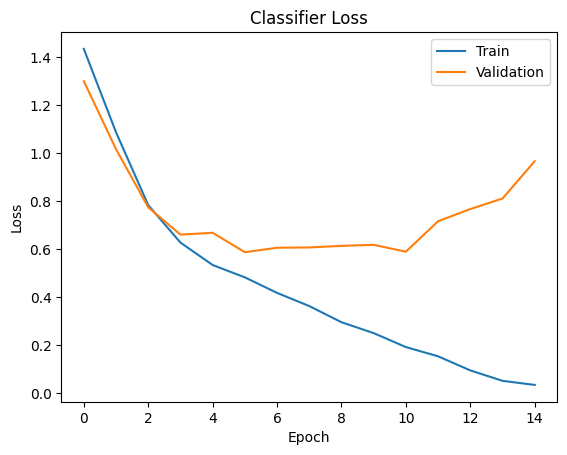

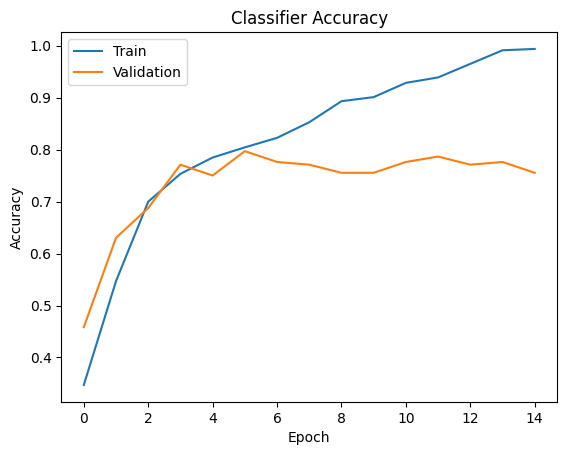

30/30 [==============================] - 32s 1s/step


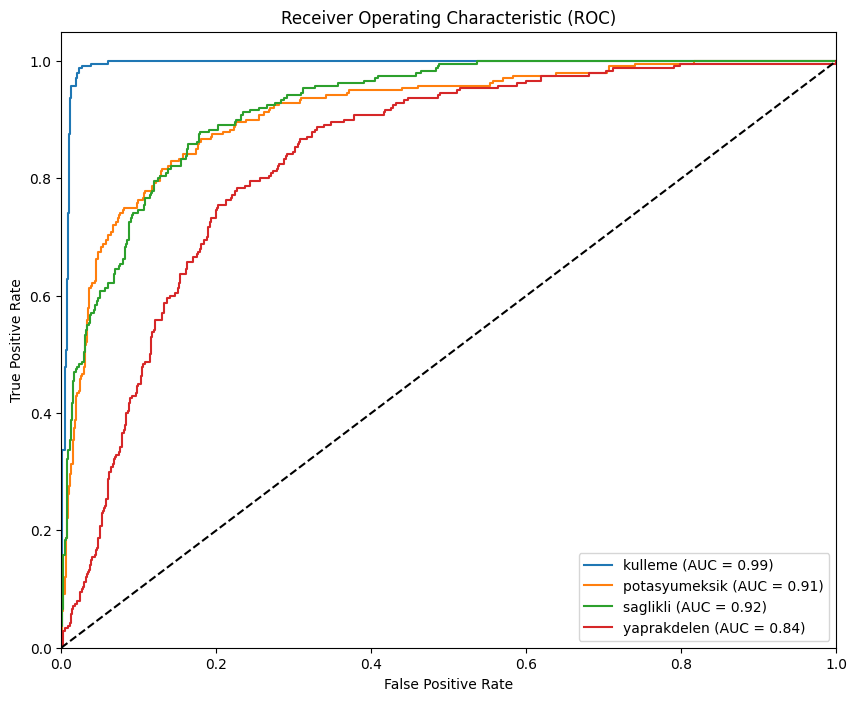

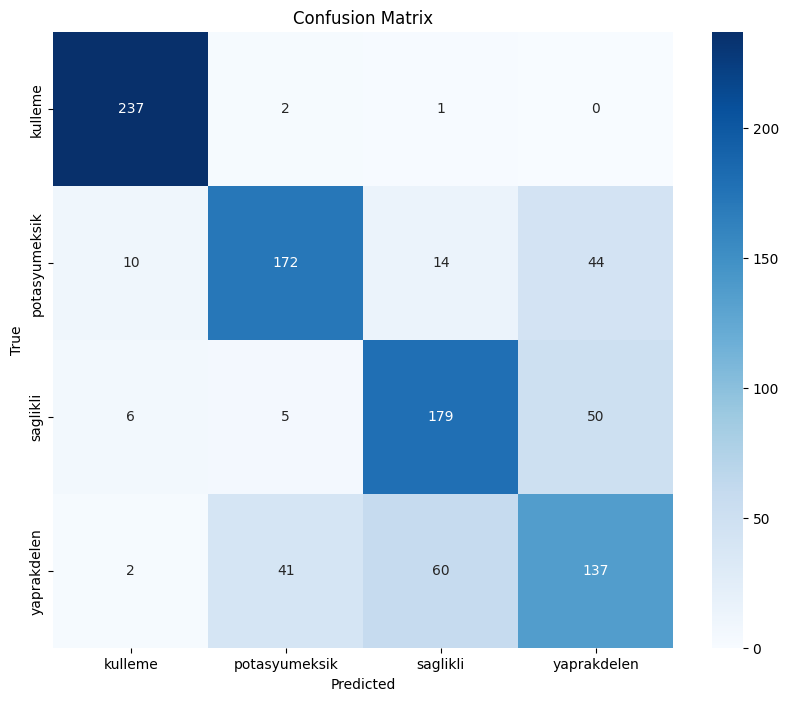

In [3]:
import pandas as pd
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import random


# Veri yolu
DATASET = "TezVeriSeti/train"
DATASET2 = "TezVeriSeti/valid"

CATEGORIES = ["kulleme", "potasyumeksik", "saglikli", "yaprakdelen"]

train_data = []
test_data = []

for category in CATEGORIES:
    label = CATEGORIES.index(category)

    # Eğitim veri kümesi
    path = os.path.join(DATASET, category)
    for img_file in os.listdir(path):
        img = cv.imread(os.path.join(path, img_file), 1)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        img = cv.resize(img, (224, 224))
        train_data.append([img, label])

    # Test veri kümesi
    path = os.path.join(DATASET2, category)
    for img_file in os.listdir(path):
        img = cv.imread(os.path.join(path, img_file), 1)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        img = cv.resize(img, (224, 224))
        test_data.append([img, label])

# Karıştırma işlemi
random.shuffle(train_data)
random.shuffle(test_data)

X_train = []
y_train = []

for features, label in train_data:
    X_train.append(features)
    y_train.append(label)

X_test = []
y_test = []

for features, label in test_data:
    X_test.append(features)
    y_test.append(label)

# Verileri numpy dizilerine dönüştürme ve normalizasyon
X_train = np.array(X_train).reshape(-1, 224, 224, 3) / 255.0
X_test = np.array(X_test).reshape(-1, 224, 224, 3) / 255.0

# Model oluşturma ve eğitim
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, Dropout

num_classes = len(CATEGORIES)

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(224, 224, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

from keras.utils import to_categorical
one_hot_train = to_categorical(y_train, num_classes=num_classes)
one_hot_test = to_categorical(y_test, num_classes=num_classes)

hist = model.fit(X_train, one_hot_train, epochs=15, batch_size=128, validation_split=0.2)

test_loss, test_acc = model.evaluate(X_test, one_hot_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Classifier Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Classifier Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Tahminler ve ROC eğrileri hesaplama
from sklearn.metrics import roc_curve, auc

y_prob = model.predict(X_test)
n_classes = len(CATEGORIES)
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(one_hot_test[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# ROC eğrileri çizdirme
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'{CATEGORIES[i]} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

# Confusion matrixi görselleştirme
from sklearn.metrics import confusion_matrix
y_pred = np.argmax(y_prob, axis=1)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=CATEGORIES, yticklabels=CATEGORIES)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
# Modeli kaydet
model.save("hazel_model.h5")
